# Import

In [1]:
import os
from datetime import datetime
from itertools import chain

import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import nibabel as nib

from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# DataLoader

In [5]:
class MyDataset(Dataset):
    def __init__(self, test_size=0.2, test=False):
        
        data_files = glob('../../brainmask_nii/*.nii')
        data_files.sort()
        
        test_num = int(test_size * len(data_files))
        train_num = len(data_files) - test_num
        shuffled_index = np.random.permutation(len(data_files))
        
        train_fname = [data_files[i] for i in shuffled_index[:train_num]]
        test_fname  = [data_files[i] for i in shuffled_index[-test_num:]]
        
        label_file = pd.read_csv('../rsc/age_ixi_and_oasis.csv', index_col=0)
        
        if test:
            self.data_files = [data_files[i] for i in shuffled_index[-test_num:]]
            self.label_file = label_file.age.values[shuffled_index[-test_num:]]
            
        else:
            self.data_files = [data_files[i] for i in shuffled_index[:train_num]]
            self.label_file = label_file.age.values[shuffled_index[:train_num]]

    def __getitem__(self, idx):
        #print(idx)
        x = torch.tensor(nib.load(self.data_files[idx]).get_fdata())[None, :, :].float() / 255
        y = torch.tensor(self.label_file[idx]).float()
        return x, y

    def __len__(self):
        return len(self.data_files)

train_dset = MyDataset()
test_dset  = MyDataset(test=True)

train_loader = DataLoader(train_dset, batch_size=8)
test_loader = DataLoader(test_dset, batch_size=8)

# 3D Convolution Model

## Modeling

In [6]:
class Conv3d(nn.Module):
    
    def __init__(self):
        super(Conv3d, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv3d(1, 8, 3, 3),
            nn.BatchNorm3d(8),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv3d(8, 16, 3, 3),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
                
        self.layer3 = nn.Sequential(
            nn.Conv3d(16, 32, 3, 3),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = x.reshape(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [7]:
model = Conv3d().float()
model.to(device)

Conv3d(
  (layer1): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(3, 3, 3))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(3, 3, 3))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(3, 3, 3))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=32, o

## Debug

In [8]:
# with torch.no_grad():
#     for i, (x, y)in enumerate(test_loader):
#         if i < 1:
#             x = x.to(device)
#             y = np.log1p(y).to(device)
            
#             y_pred = torch.Tensor(np.exp(model.forward(x).cpu().numpy())).to(device)

#             loss = loss_fn(y_pred, y)
#         else:
#             break

## Passing through Model

In [9]:
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
loss_fn = nn.MSELoss()

In [ ]:
epochs = range(20)

trn_losses, tst_losses = [], []

summary = SummaryWriter(f'./tensorboard/{datetime.now().strftime("%Y-%m-%d_%H%M")}')
for e in epochs:
    
    trn_bth_loss = 0
    model.train()
    for i, (x, y) in enumerate(train_loader):
        # x, y = x.to(device), y.to(device)
        x, y = x.to(device), np.log1p(y).to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x).to(device)
        
        loss = loss_fn(y_pred, y)
        del x, y, y_pred

        loss.backward()
        optimizer.step()

        trn_bth_loss += loss.item()
        
        if not i % 20:
            print(f'{i:<4}th Batch. Loss: {loss.item():.3f}')

    torch.cuda.empty_cache()
    trn_losses.append(trn_bth_loss / len(train_loader))
        
        
    tst_bth_loss = 0
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            # x, y = x.to(device), y.to(device)
            x, y = x.to(device), np.log1p(y).to(device)
            
            y_pred = model.forward(x).to(device)
            
            loss = loss_fn(y_pred, y)
            del x, y, y_pred

            tst_bth_loss += loss.item()

    tst_losses.append(tst_bth_loss / len(test_loader))
    torch.cuda.empty_cache()
    
    summary.add_scalars('loss/MSE_loss',
                        {'Train Loss': trn_losses[-1],
                         'Valid Loss': tst_losses[-1]}, e)
    summary.add_scalar('lr', lr, e)
    
    # Print
    print(f'EPOCHS {e} | TRAIN :: [LOSS] {trn_losses[-1]:.3f} | VALID :: [LOSS] {tst_losses[-1]:.3f}')

C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0   th Batch. Loss: 21.814
20  th Batch. Loss: 19.409
40  th Batch. Loss: 13.262
60  th Batch. Loss: 13.988
80  th Batch. Loss: 10.802
100 th Batch. Loss: 9.207


C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


EPOCHS 0 | TRAIN :: [LOSS] 13.339 | VALID :: [LOSS] 10.754
0   th Batch. Loss: 10.244
20  th Batch. Loss: 7.891
40  th Batch. Loss: 5.165
60  th Batch. Loss: 5.581
80  th Batch. Loss: 4.469
100 th Batch. Loss: 3.730
EPOCHS 1 | TRAIN :: [LOSS] 5.183 | VALID :: [LOSS] 6.393
0   th Batch. Loss: 3.479
20  th Batch. Loss: 2.596
40  th Batch. Loss: 1.513
60  th Batch. Loss: 1.985
80  th Batch. Loss: 1.242
100 th Batch. Loss: 1.336
EPOCHS 2 | TRAIN :: [LOSS] 1.529 | VALID :: [LOSS] 3.866
0   th Batch. Loss: 1.221
20  th Batch. Loss: 0.913
40  th Batch. Loss: 0.537
60  th Batch. Loss: 0.731
80  th Batch. Loss: 0.444
100 th Batch. Loss: 0.729
EPOCHS 3 | TRAIN :: [LOSS] 0.554 | VALID :: [LOSS] 3.018
0   th Batch. Loss: 0.369
20  th Batch. Loss: 0.440
40  th Batch. Loss: 0.332
60  th Batch. Loss: 0.391
80  th Batch. Loss: 0.546
100 th Batch. Loss: 0.500
EPOCHS 4 | TRAIN :: [LOSS] 0.419 | VALID :: [LOSS] 2.929
0   th Batch. Loss: 0.108
20  th Batch. Loss: 0.266
40  th Batch. Loss: 0.315
60  th Bat

# Plot Result

### Loss

In [ ]:
plt.plot(trn_losses)
plt.plot(tst_losses)
plt.legend(['Train Loss', 'Val Loss'])
plt.title('Loss / Epochs')
plt.xlabel('Epochs')
#plt.xticks(np.arange(0, 20, step=2), [x for x in np.arange(0, 20, step=2)])
plt.ylabel('MSE Loss')
plt.grid()
plt.show()

### Regression Accuracy

In [19]:
import seaborn as sns

In [143]:
def sns_result(trues, preds, title='Train', fname=None):
    
    data = pd.DataFrame({
        "Prediction": np.array(list(chain(*preds))),
        "True": np.array(list(chain(*trues))),
    })
    
    cut = max(max(abs(data["Prediction"].values)), max(abs(data["True"].values)))
    cuts = [-cut, cut]
    
    plt.figure(figsize=(14, 14))
    
    g = sns.jointplot(data=data, x="Prediction", y="True",
                 xlim=cuts, ylim=cuts, kind="reg", height=10, ratio=4)
    g.fig.suptitle(f'{title} Dataset Prediction')
    domain = np.linspace(*cuts, 100)
    plt.plot(domain, domain, c='black')

<Figure size 1008x1008 with 0 Axes>

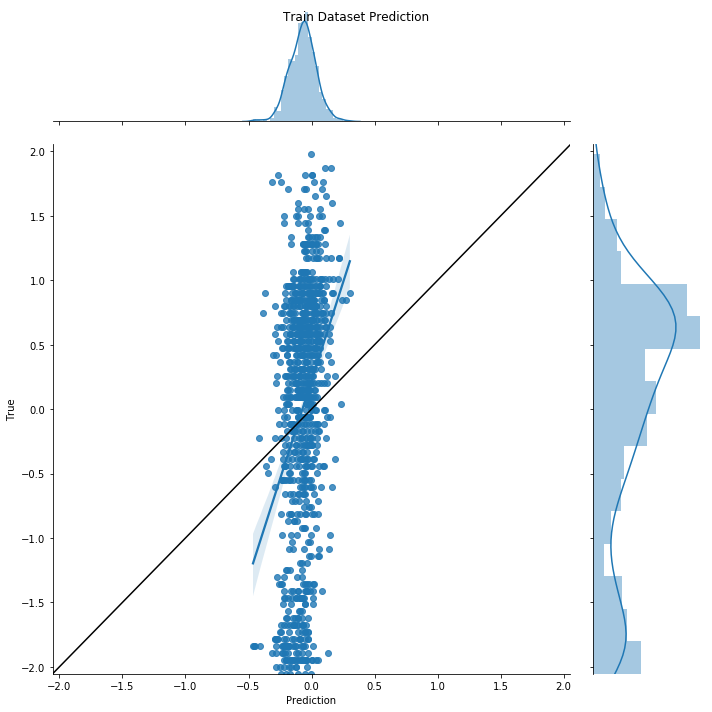

In [144]:
sns_result(train_true, train_pred)

In [ ]:
def plot_result(trues, preds, title='Train', fname=None):
    preds = np.array(list(chain(*preds)))
    trues = np.array(list(chain(*trues)))
    
    cut = max(max(abs(preds)), max(abs(trues)))
    cuts = [-cut, cut]
              
    plt.figure(figsize=(9, 9))
    plt.scatter(preds, trues)
    plt.xlim(*cuts)
    plt.ylim(*cuts)
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title(f'{title} Dataset Prediction')
    plt.grid()
    domain = np.linspace(*cuts, 100)
    plt.plot(domain, domain, c='black')
    if fname:
        plt.savefig(f'./result/{fname}_{title}.png')
    plt.show()

In [ ]:
fname = f'{datetime.now().strftime("%Y-%m-%d_%H%M-")}_lr{lr}'

### Train

In [14]:
model.eval()
train_true, train_pred = [], []
with torch.no_grad():
    for i, (x, y) in enumerate(tqdm(train_loader)):

        x, y = x.to(device), y.to(device)
        y_pred = model.forward(x).to(device)

        train_pred.append(y_pred.to('cpu'))
        train_true.append(y.to('cpu'))

        del x, y, y_pred
        torch.cuda.empty_cache()

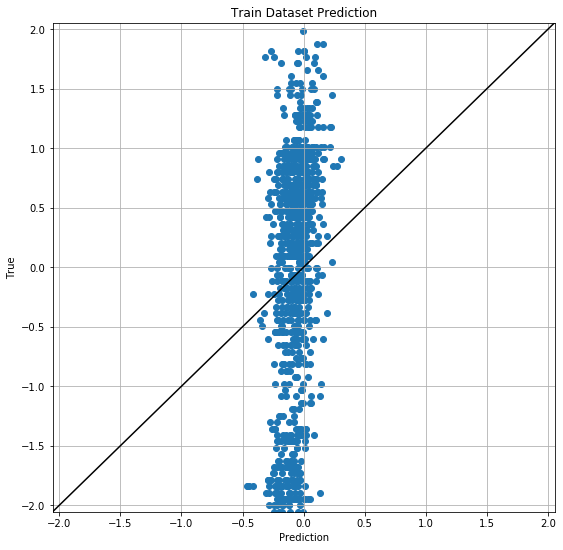

In [15]:
plot_result(train_true, train_pred, fname=fname)

### Test

In [16]:
model.eval()
test_true, test_pred = [], []
with torch.no_grad():
    for i, (x, y) in enumerate(tqdm(test_loader)):

        x, y = x.to(device), y.to(device)
        y_pred = model.forward(x).to(device)

        test_pred.append(y_pred.to('cpu'))
        test_true.append(y.to('cpu'))

        del x, y, y_pred
        torch.cuda.empty_cache()

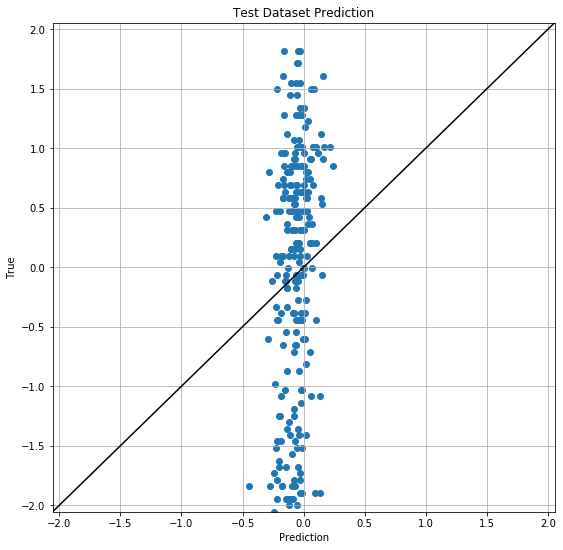

In [17]:
plot_result(test_true, test_pred, title='Test', fname=fname)

## Save Model

In [18]:
torch.save(model, f"./models/{fname}_model.pth")